**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Elcio Hideiti Shiguemori

Gabriel Adriano de Melo

Marcos Ricardo Omena de Albuquerque Maximo

**Orientações padrão:**

Antes de você entregar o Lab, tenha certeza de que tudo está rodando corretamente (sequencialmente): Primeiro, **reinicie o kernel** (`Runtime->Restart Runtime` no Colab ou `Kernel->Restart` no Jupyter), depois rode todas as células (`Runtime->Run All` no Colab ou `Cell->Run All` no Jupyter) e verifique que as células rodem sem erros, principalmente as de correção automática que apresentem os `assert`s.

É muito importante que vocês não apaguem as células de resposta para preenchimento, isto é, as que contenham o `ESCREVA SEU CÓDIGO AQUI` ou o "ESCREVA SUA RESPOSTA AQUI", além das células dos `assert`, pois elas contém metadados com o id da célula para os sistemas de correção automatizada e manual. O sistema de correção automatizada executa todo o código do notebook, adicionando testes extras nas células de teste. Não tem problema vocês criarem mais células, mas não apaguem as células de correção. Mantenham a solução dentro do espaço determinado, por organização. Se por acidente acontecer de apagarem alguma célula que deveria ter a resposta, recomendo iniciar de outro notebook (ou dar um `Undo` se possível), pois não adianta recriar a célula porque perdeu o ID.

Os Notebooks foram programados para serem compatíveis com o Google Colab, instalando as dependências necessárias automaticamente a baixando os datasets necessários a cada Lab. Os comandos que se inicial por ! (ponto de exclamação) são de bash e também podem ser executados no terminal linux, que justamente instalam as dependências.

---

# Lab de Processamento 3d

Neste laboratório iremos revisar o modelo de câmera a fim de aplicar em um exemplo de perspectiva de n pontos, de calibração estéreo e também de retificação a fim de facilitar a correspondência estéreo. Por fim veremos um exemplo do mapa de disparidade.

In [1]:
# !pip3 install opencv-contrib-python==4.6.0.66 Pillow==7.1.2 matplotlib==3.2.2 scipy==1.7.3 gdown

import cv2
import numpy as np
import PIL.Image
from matplotlib import pyplot as plt
from glob import glob
from pathlib import Path
from scipy.spatial.transform import Rotation as R

plt.style.use('seaborn-darkgrid')

Se for executar local e quiser alterar o Path, pode alterar aqui sem problemas para a correção automática.

In [2]:
! [ ! -d "/content/calib_esq" ] && gdown -O /content/calib_esq.zip 1vg2fnoLjcYAdF44HxwK41basZUj0xYMN && unzip /content/calib_esq.zip -d /content && rm /content/calib_esq.zip
! [ ! -d "/content/calib_dir" ] && gdown -O /content/calib_dir.zip 1d0OeP9YCxx1sWjwDMvf0y6f35Lx3ELPN && unzip /content/calib_dir.zip -d /content && rm /content/calib_dir.zip
! [ ! -d "/content/tsukuba" ] && gdown -O /content/tsukuba.zip 1Ghpx9_x8E26SzJP3X-Itt94QD3yVM8lT && unzip /content/tsukuba.zip -d /content && rm /content/tsukuba.zip
root_path = Path("/content")
imgs_esq_path = root_path/"calib_esq"
imgs_dir_path = root_path/"calib_dir"
tsukuba_path = root_path/"tsukuba"

Downloading...
From: https://drive.google.com/uc?id=1vg2fnoLjcYAdF44HxwK41basZUj0xYMN
To: /content/calib_esq.zip
100% 42.9M/42.9M [00:00<00:00, 177MB/s]
Archive:  /content/calib_esq.zip
   creating: /content/calib_esq/
  inflating: /content/calib_esq/00.png  
  inflating: /content/calib_esq/01.png  
  inflating: /content/calib_esq/02.png  
  inflating: /content/calib_esq/03.png  
  inflating: /content/calib_esq/04.png  
  inflating: /content/calib_esq/05.png  
  inflating: /content/calib_esq/06.png  
  inflating: /content/calib_esq/07.png  
  inflating: /content/calib_esq/08.png  
  inflating: /content/calib_esq/09.png  
  inflating: /content/calib_esq/10.png  
  inflating: /content/calib_esq/11.png  
  inflating: /content/calib_esq/12.png  
  inflating: /content/calib_esq/13.png  
  inflating: /content/calib_esq/14.png  
  inflating: /content/calib_esq/15.png  
  inflating: /content/calib_esq/16.png  
  inflating: /content/calib_esq/17.png  
  inflating: /content/calib_esq/18.png  
  

No Jupyter notebook, aperte Shift+TAB seguidas vezes (uma, duas ou três) para aparecer um tooltip com a assinatura de uma função. No Colab, para fazer isso com o TAB tem que primeiro desativa o `Automatically trigger code completions` no `Tools->Settings->Editor`, se não ele só vai aparecer automaticamente quando você começar a digitar a função, mas não com o TAB.

![Jupyter Notebook Tooltip](https://camo.githubusercontent.com/88055882678674dd9c9e084ffa7d096ad9723d4ed6736e51f050a69d8fb307d0/687474703a2f2f672e7265636f726469742e636f2f4b7955513569754a64762e676966)

Você também pode colocar um ponto de interrogação no final de uma função para abrir o help dela:

In [3]:
cv2.imread?

## Revisão Modelo da Câmera

Essa parte inicial é apenas uma revisão básica com funções cuja solução é apenas uma linha. A intenção é exercitar e revisar alguns conceitos básicos, para que você consiga estimar a matriz intrínseca de uma câmera sem precisar de calibração com tabuleiro de xadrez (apenas com algumas especificações, como FoV+resolução ou distância focal+tamanho do sensor.

### Equivalência Lente Pinhole
Nesta primeira etapa vamos relembrar algumas propriedades do modelo de câmera projetiva. O nosso modelo de projeção é retilinear, que é o mesmo obtido por uma câmera pinhole, no qual os raios de luz convergem (são filtrados) em um único ponto (centro de projeção) e terminam em um aparato (sensor), formando uma imagem invertida (nos dois eixos).
Uma câmera de lente delgada (ou ainda um conjunto de lentes que seja equivalente, o que é o caso das câmeras de hoje em dia que são várias lentes) também é equivalente ao modelo pinhole.


**ENTENDA:** Tenha cuidado com os termos de distância focal, que muita gente confunde, pois na prática são próximos numericamente, como veremos a diante. Nas equações de projeção, de calibração, de cálculo de FOV simplificado, o que nós estamos nos referindo quando falamos em **DISTÂNCIA FOCAL**, é o equivalente do modelo pinhole $f_{pinhole}$ da figura abaixo, isto é, a distância do centro de projeção até o plano de projeção, como ilustrado na figura abaixo.

![Modelo de Câmera Pinhole](https://gam.dev/cm203/imgs/pinhole.svg)

Já a lente (ou sistema de lentes) tem a sua própria distância focal $f_{lente}$ e a distância da lente até a imagem formada $d_i$ é função do plano de foco, isto é, a distância do objeto $d_i$ que está em foco até a lente. Conforme figura abaixo. Essa relação é regida pela equação das lentes delgadas (que é apenas semelhança de triangulos), a ser aplicada no exercício adiante.

Assim perceba que a equivalência é entre $d_i$ e $f_{pinhole}$ e não ao $f_{lente}$. Quando o objeto estiver longe ($d_o >> f$), inevitavelmente $d_i$ vai se aproximar de $f_{lente}$.

![Modelo de Câmera com Lente Equivalente](https://gam.dev/cm203/imgs/lens.svg)

Assim, vamos calcular essa equivalência, implemente a função abaixo: (0,5 pontos)

In [4]:
def distancia_focal_pinhole_equivalente(f_lente, d_o):
    """
    Implemente a equação que calcula a distância focal equivalente a uma câmera pinhole (d_i)
    com a restrição de 0 < lens_focal_lenght < focus_plane_distance
    :param f_lente: distância focal da lente, em metros
    :param d_o: distância da lente ao plano do objeto em foco, em metros
    Retorna a distância focal equivalênte a uma câmera pinhole, em metros
    """
    d_i = np.divide(np.multiply(f_lente,d_o),(d_o-f_lente))
    f_pinhole = d_i
    return f_pinhole

Lembre da equação das lentes:

![Equação das Lentes Delgadas](https://gam.dev/cm203/imgs/lentes_delgadas.svg)

Verifique se a sua implementação está correta executando a célula abaixo (0,5 pontos).

Perceba no caso de teste que para uma distância focal de 8 mm e um plano de foco a 10 m, $f_{pinhole}$ é praticamente igual a $f_{lente}$, uma diferença menor que 0.08%.

Essas células com `assert` serão corrigidas automaticamente pelo corretor, nós deixamos pelo menos um caso de teste visível para vocês verificarem que está certo, mas claro que temos outros casos de teste, então nem adianta criar uma função que retorna uma constante.

Essa célula, juntamente com a célula assim tem um ID de metadado que é usado para a correção automática, então se por acaso você apagá-la, só pode desfazer pelo `Edit->Undo`, não adianta criar uma nova célula e copiar o código porque perdeu o ID. Se o Undo não funcionar, recomendo baixar o notebook de novo e cópiar as suas soluções para o notebook novo com a célula original.

In [5]:
assert abs(distancia_focal_pinhole_equivalente(0.008,  10) - 0.00800640) < 1e-6
# OBS: implemente uma função np friendly (que eu consiga passar um vetor de numpy)
assert abs(distancia_focal_pinhole_equivalente(np.array([0.008]),  np.array([10.])) - 0.00800640) < 1e-6

### Campo de Visão FoV

Agora vamos calcular o FOV (em graus) de uma câmera pinhole com base na largura do sensor e a distância do sensor ao centro de projeção, considerando que o centro de projeção coincida com o centro da imagem.

![Campo de Visão (Field of View) FoV](https://gam.dev/cm203/imgs/fov.svg)

Implemente a fução abaixo que calcula o FoV (0,5 pontos)

<details><summary><b>Dica</b></summary>
<p>
Usar a função `np.arctan` e a constante `np.pi`.
</p>
</details>

In [6]:
def calcula_fov(f_pinhole, largura_sensor):
    """
    Calcula o campo de visão em graus de uma câmera pinhole
    :param f_pinhole: distância focal da câmera pinhole, em metros
    :param largura_sensor: largura do sensor, em metros
    Retorna o campo de visão FoV em graus
    """
    FoV = np.rad2deg(2*np.arctan(largura_sensor/(2*f_pinhole)))
    return FoV

In [7]:
assert abs(calcula_fov(1,  2) - 90) < 1e-6
# OBS: implemente uma função np friendly (que eu consiga passar um vetor de numpy)
assert abs(calcula_fov(np.array([1.]),  np.array([2.]))[0] - 90) < 1e-6

Agora vamos fazer o mesmo cálculo, mas agora considerando um modelo de lente que esteja focada a uma distância certa distância ($d_o$), isto é a distância ao plano em foco. (0,5 pontos)

In [8]:
def calcula_fov_lente(f_lente, largura_sensor, distancia_plano_em_foco):
    """
    Calcula o campo de visão em graus de uma câmera de lente delgada
    :param f_lente: distância focal da lente, em metros
    :param largura_sensor: largura do sensor, em metros
    :param distancia_plano_em_foco: distância da lente ao plano do objeto em foco, em metros
    Retorna o campo de visão FoV em graus
    """
    f_pinhole = distancia_focal_pinhole_equivalente(f_lente,distancia_plano_em_foco)
    FoV = calcula_fov(f_pinhole,largura_sensor)
    return FoV

In [9]:
assert abs(calcula_fov_lente(0.001,  0.002, 100) - 89.999427) < 1e-6
# OBS: implemente uma função np friendly (que eu consiga passar um vetor de numpy)
assert abs(calcula_fov_lente(np.array([0.001]),  np.array([0.002]), np.array([100.]))[0] - 89.999427) < 1e-6

Perceba que o FoV varia bem pouco em função da distância do plano em foco. A variação é maior para objetos que estão mais próximos

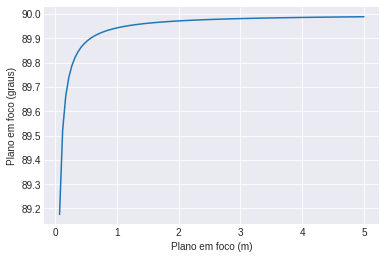

In [10]:
plt.plot(np.linspace(0.07, 5, 99), calcula_fov_lente(np.array([0.001]*99), np.array([0.002]*99), np.linspace(0.07, 5,99)))
plt.xlabel('Plano em foco (m)')
plt.ylabel('Plano em foco (graus)')
plt.show()

Agora vamos partir para um caso em que você pode usar na prática, quando o fabricante de uma câmera nos dá o campo de visão em graus e nós sabemos a largura em pixels da imagem que ela forma, vamos calcular qual a distância focal equivalente pinhole em pixels que ela nos dá. É esse $f_{pinhole}$ que usamos na matriz intríseca do formato do OpenCV. Nessa caso eu falo em largura e FoV horizontal mas também é a mesma coisa para a altura e FoV vertical. (0,5 pontos)


<details><summary><b>Dica</b></summary>
<p>
Use `np.tan`
</p>
</details>

In [11]:
def calcula_dist_focal_pixels(FoV, largura_pixels):
    """
    Calcula a distância focal em pixels de uma câmera pinhole, 0 < FoV < 180
    :param FoV: Campo de Visão da câmera em graus
    :param largura_pixels: Largura do sensor (da imagem formada) em pixels
    Retorna a distância focal equivalente pinhole em pixels.
    """
    f_pinhole = largura_pixels/(2*np.tan(np.deg2rad(FoV)/2))
    return f_pinhole

In [12]:
assert abs(calcula_dist_focal_pixels(90, 1920) - 960) < 1e-6

No exercício acima, a distância focal está em pixels, mas também se quisermos converter em metros, teríamos que saber o tamamho do pixel (pixel size), ou de forma equivalente, a largura efetiva do sensor. Assim, seria apenas fazer uma conversão simples de unidades de pixels para metros.

Espero que nessa etapa você tenha entendido a relação de equivalência entre a projeção retilinear (dada por uma câmera pinhole) e uma câmera com um conjunto de lentes delgadas, e principalmente que a distância focal equivalente pinhole dessas câmeras varia de acordo com o plano de foco (onde a imagem está focada), o que influencia até no FoV.

### Coordenadas Homogêneas e Geometria Projetiva

Vamos agora para o modelo projetivo: 

Para facilitar a matemática, isto é, não precisar inverter imagem nem se preocupar com coordenadas negativas em z, vamos colocar o plano de projeção à frente do centro de projeção.

Perceba que o resultado é equivalente: a imagem projetada possui exatamente as mesmas dimensões, e a distância focal se mantém a mesma em módulo.

![Câmera Pinhole Plano de projeção Frontal](https://gam.dev/cm203/imgs/pinhole_cam.svg)

Observe agora o nosso sistema de coordenadas da câmera, no qual a nossa origem está no Centro de Projeção. O nosso plano de projeção é ortogonal ao eixo Z, que aponta para fora da câmera.

![Câmera Pinhole Plano de projeção Frontal](https://gam.dev/cm203/imgs/pinhole_cam_proj.svg)

Um ponto no mundo real $(X, Y, Z)$ medido em metros é projetado no plano da projeção por uma simples semelhança de triângulo, sabendo que o plano de projeção está afastado a uma distância $f_{metros}$ da origem (em metros, distância focal pinhole equivalente), em metros: $(X_p, Y_p, Z_p) = (X\frac{f_{metros}}{Z}, Y\frac{f_{metros}}{Zf_{metros}}, f)$ ainda em metros. OBS: estou chamando o $f_{pinhole}$ de $f_{metros}$ para dar ênfase nas unidades para que você não se confunda, é claro que metros poderia ser qualquer outra unidade medida, só quero diferenciar de pixels.


![Câmera Pinhole Plano de projeção Frontal](https://gam.dev/cm203/imgs/pinhole_cam_proj_ext.svg)


Se não fosse esse $Z$ dividindo, seria uma transformação linear e poderíamos escrever em forma de matriz. Agora vem o conceito de coordenadas homogêneas ao resgate! Basta acrescentar uma nova dimensão que vai servir como o *divisor* da normalização. Assim podemos expressar todas essas operações de divisão e até de soma como uma única multiplicação matricial.

Para transformar um ponto N-dimensional cartesiano para seu equivalente homogêneo, basta acrescentar uma nova dimensão com valor unitário. E no inverso, basta dividir por esse valor, com cuidado para pontos no infinito (divisão por zero). Assim o ponto 2d cartesiano $(X, Y)$ fica $(X, Y, 1)$ no homogêneo. O ponto $(X, Y, Z, W)$ homogêneo fica $(X/W, Y/W, Z/W)$ no cartesiano. Veja que há infinitos pontos do homogeneo que mapeiam no mesmo do cartesiano.

Assim nos exercícios abaixo (0,5 pontos cada), implemente a transformação de coordenada cartesiana para homogênea e virse-versa. Não se preocupe com os pontos no infinito.

Matematicamente é trivial, mas deixei esses dois exercícios para vocês ficarem espertos com o numpy, a indexação, concatenação de vetores, e formato (shape). Principalmente o shape dos vetores que muita gente confunde e faz perder o shape quando indexa o vetor coluna.

<details><summary><b>Dica</b></summary>
<p>
Use `np.vstack` (que recebe uma lista de vetores coluna), na hora de indexar use o operador `:` em todos os índices, use o índice `-1` para selecionar o último elemento.
</p>
</details>

In [13]:
def cartesiano_para_homogeneo(vetor):
    """
    Transforma de coordenadas cartesianas para homogêneas
    :param vetor: Vetor coluna numpy em coordenada cartesiana
    Retorna um vetor coluna numpy em coordenada homogênea
    """
    vetor_coord_homogenea = np.vstack((vetor,[1]))   
    return vetor_coord_homogenea

In [14]:
assert np.linalg.norm(cartesiano_para_homogeneo(np.array([[2],
                                                          [4]])) - np.array([[2],
                                                                             [4],
                                                                             [1]])) < 1e-6
assert np.linalg.norm(cartesiano_para_homogeneo(np.array([[19],
                                                          [19],
                                                          [19]])) - np.array([[19],
                                                                              [19],
                                                                              [19],
                                                                              [1 ]])) < 1e-6

In [15]:
def homogeneo_para_cartesiano(vetor_coord_homogenea):
    """
    Transforma de coordenadas homogêneas para cartesiana, sem se preocupar com ponto no infinito.
    :param vetor_coord_homogenea: Vetor coluna numpy em coordenada homogênea
    Retorna um vetor coluna numpy em coordenada cartesiana
    """
    vetor = vetor_coord_homogenea[:-1,:]/vetor_coord_homogenea[-1,:]
    return vetor

In [16]:
assert np.linalg.norm(homogeneo_para_cartesiano(np.array([[4],
                                                          [8],
                                                          [2]])) - np.array([[2],
                                                                             [4]])) < 1e-6
assert np.linalg.norm(homogeneo_para_cartesiano(np.array([[19],
                                                          [19],
                                                          [19],
                                                          [19]])) - np.array([[1],
                                                                              [1],
                                                                              [1]])) < 1e-6

Mas nós queremos saber não onde está o ponto no sensor em metros, mas sim onde está o ponto na imagem em pixels, e lá vamos nós com uma simples regra de três (transformação linear):

Primeiro temos que saber onde que o ponto $(0, 0, f_{metros})$ do plano de projeção está na imagem em pixels, que é o $(c_x, c_y)$. Depois, temos que saber a relação entre pixels e metros para transformar a distância focal de metros para pixels, isto é, o que chamamos de tamanho do pixel $\mu$.

Assim o nosso ponto 3d $(X_p, Y_p, Z_p)$ medido em metros vira simplesmente um ponto 2d $\left(c_x + X_p\mu, c_y + Y_p\mu\right)$ medido agora em pixels, na imagem. Substituindo, temos $\left(c_x + X\frac{f_{metros}}{Z}\mu, c_y + Y\frac{f_{metros}}{Z}\mu\right)$

Perceba que o termo $f_{metros} \mu$ é justamente a conversão da distância focal em metros para pixels, que vamos chamar agora simplesmente de $f$ que a convenção que o OpenCV usa, para a distância focal equivalente pinhole medida em pixels.

Assim, temos o mapeamento de um ponto 3d $(X, Y, Z)$ em metros para $\left(c_x + X\frac{f}{Z}, c_y + Y\frac{f}{Z}\right)$, sendo os valores de $c_x$, $c_y$ e $f$ medidos em pixels.

Em vez só de pesquisar a matriz de transformação projetiva na internet ou na aula direto, tente pensar um pouco. Lembre que a saída é em coordenada homogênea, então não se preocupe com a divisão pelo $Z$. (0,5 pontos)

<details><summary><b>Dica de Numpy</b></summary>
<p>
Use operador `@` do numpy para multiplicação matricial `A @ B` equivale a `np.dot(A, B)`. A transformação de projeção é simplesmente uma multiplicação matricial da matriz de transformação pela coordenada, o que resulta em uma coordenada projetada em formato homogêneo.
</p>
</details>

In [17]:
def transformacao_projetiva_3d(ponto3d, c_x, c_y, f):
    """
    Projeta um ponto no espaço para um ponto no plano em coordenadas homogêneas
    :param ponto3d: ponto 3d em metros no formato de vetor coluna numpy
    :param c_x: coordenadas no eixo x do ponto principal, em pixels
    :param c_y: coordenadas no eixo y do ponto principal, em pixels
    :param f: distância focal em pixels
    Retorna um vetor coluna homogêneo referente à projeção e a matriz de transformação dessa projeção
    """
    matriz_transformacao = np.array([[f,0,c_x],[0,f,c_y],[0,0,1]])
    ponto_projetado_2d_homogeneo = matriz_transformacao@ponto3d
    return ponto_projetado_2d_homogeneo, matriz_transformacao

In [18]:

ponto, mtx = transformacao_projetiva_3d(np.array([[1],[1],[1]]), 1, 1, 1) # Tudo 1 para não espiar :)
assert np.linalg.norm(mtx/mtx[-1,-1] - np.array([[1, 0, 1], [0, 1, 1], [0, 0, 1]])) < 1e-6
assert np.linalg.norm(homogeneo_para_cartesiano(ponto) - np.array([[2], [2]])) < 1e-6

Além do mapeamento anterior que leva a $\left(c_x + X\frac{f}{Z}, c_y + Y\frac{f}{Z}\right)$, pode-se considerar também uma distância focal diferente entre os eixos $x$ e $y$ da imagem, como se houvesse um achatamento em alguma dimensão (seja por uma lente cilíndrica, ou sensels (sensor de pixels) que não seja quadrados, ou redimensionamento). Dá-se o nome de *aspect ratio* $f_y = a f_x$ a esse quociente $a = \frac{f_y}{f_x}$ (dependendo da biblioteca pode ser o recíproco).

Outro termo, encontrado com menor frequência, é o *skew* da imagem, que modeleraria o caso das linhas dos sensores estiverem desalinhadas, formando um paralelogramo em vez de um retângulo, ou ainda para corrigir o fenômeno que ocorre em nas câmeras de *rolling shutter* quando a região de imagem está sempre se movendo a velocidade linear constante com relação à câmera. O OpenCV não apresenta esse parâmetro em seu modelo de calibração.

Assim o modelo completo fica: $\left(c_x + \frac{X f_x + Y skew}{Z}, c_y + Y\frac{f_y}{Z}\right)$. Reescreva a equação acima de forma a isolar a matriz de projeção, retornando apenas a matriz intríseca da câmera que é exatamente a matriz de projeção com o cuidado de que o último termo é unitário. (0,5 pontos)

In [19]:
def forma_matriz_intriseca(c_x, c_y, f_x, f_y, skew):
    """
    Forma a Matriz intrínseca (mtx) de uma câmera definida pelos parâmetros c_x, c_y, f_x, f_y, skew
    Atente ao fato de que ela multiplicada por um vetor coluna de um ponto no mundo é o ponto homogêno na imagem
    mtx @ np.array([[X],[Y],[Z]]) = np.array([[X*f_x+skew*Y+c_x*Z],[Y*f_y+c_y*Z],[Z]])
    :param c_x: coordenadas no eixo x do ponto principal, em pixels
    :param c_y: coordenadas no eixo y do ponto principal, em pixels
    :param f_x: distância focal em pixels no eixo x
    :param f_y: distância focal em pixels no eixo y
    :param skew: coeficiente de cisalhamento, em pixels
    Retorna mtx, atente que nesse caso mtx[2, 2] é necessariamente igual a 1 (normalizado).
    """
    matriz_intrinseca = np.array([[f_x,skew,c_x],[0,f_y,c_y],[0,0,1]])
    return matriz_intrinseca

In [20]:
mtx = forma_matriz_intriseca(1, 1, 1, 1, 1) # Tudo 1 para não espiar :) mas temos mais testes, cuida
assert np.linalg.norm(mtx - np.array([[1, 1, 1], [0, 1, 1], [0, 0, 1]])) < 1e-6

## Perspectiva de N Pontos

Vamos fazer uma aplicação direta da Perspectiva de N Pontos e refletir sobre suas limitações. A Perspectiva de N Pontos encontra a rotação e translação que minimizam o erro de reprojeção, dados os parâmetros intrísecos da câmera (já conhecidos).

Encontre a pose da carga externa. Use a função `cv2.solvePnP`. 
Utilize também a flag `cv2.SOLVEPNP_EPNP`, pois o default `cv2.SOLVEPNP_ITERATIVE`, se não passsar uma estimativa inicial para o `[R, T]`, ele resolve um sistema linear (DLT) para fazer essa estimativa, e precisa de mais pontos.
(1 ponto)

In [21]:
def encontra_pose_pnp(verts3d, verts2d, parametros_camera):
    """
    Determina a pose de um objeto no espaço, dado sua geometria, os pontos correspondentes e a câmera calibrada
    :param verts3d: as coordenadas dos pontos 3d de um objeto em seu referencial próprio, em metros
    :param verts2d: as posições encontradas desses pontos na imagem, em pixels
    :param parametros_camera: tupla com a matrix intríseca e coeficientes de distorção
    Retorna o erro de reprojeção e os vetores de rotação (notação de Rodrigues, em radianos) e o de translação,
    que define a pose do objeto com relação à câmera
    """
    matrix_intrinseca, coefs_distorcao = parametros_camera
    erro_reprojecao,rvec, tvec = cv2.solvePnP(verts3d,verts2d,matrix_intrinseca,coefs_distorcao, flags = cv2.SOLVEPNP_EPNP)
    return erro_reprojecao, rvec, tvec

Veja que no teste abaixo parte-se de uma geometria e pose aleatórios

In [22]:
verts3d = np.array([[-1,-1,0],[-1,1,0],[1,1,0],[1,-1,0],[0,0,2]], dtype=np.float32)
mtx = np.array([[1000,0,1000],[0,1000,500],[0,0,1]], dtype=np.float32)
dist = np.zeros((5,), dtype=np.float32)
rvec = np.array([[0.3], [-0.2], [0.6]])
tvec = np.array([[0.1], [-0.2], [7]])
verts2d, _ = cv2.projectPoints(verts3d, rvec, tvec, mtx, dist)
erro_reprojecao, rvec_rec, tvec_rec = encontra_pose_pnp(verts3d, verts2d, (mtx, dist))
assert np.linalg.norm(R.from_rotvec(rvec.ravel()).as_matrix() - R.from_rotvec(rvec_rec.ravel()).as_matrix()) < 0.01
assert np.linalg.norm(tvec - tvec_rec) < 0.001

Vamos visualizar a projeção desses pontos no espaço. Fique a vontade para alterar os valores de rvec e tvec e a matriz intrínseca.

Aqui estamos apenas ligando os pontos projetados com linhas verdes entre si, para tentar dar a noção do objeto no espaço (já está virando computação gráfica, o Doppelgänger da visão computacional).

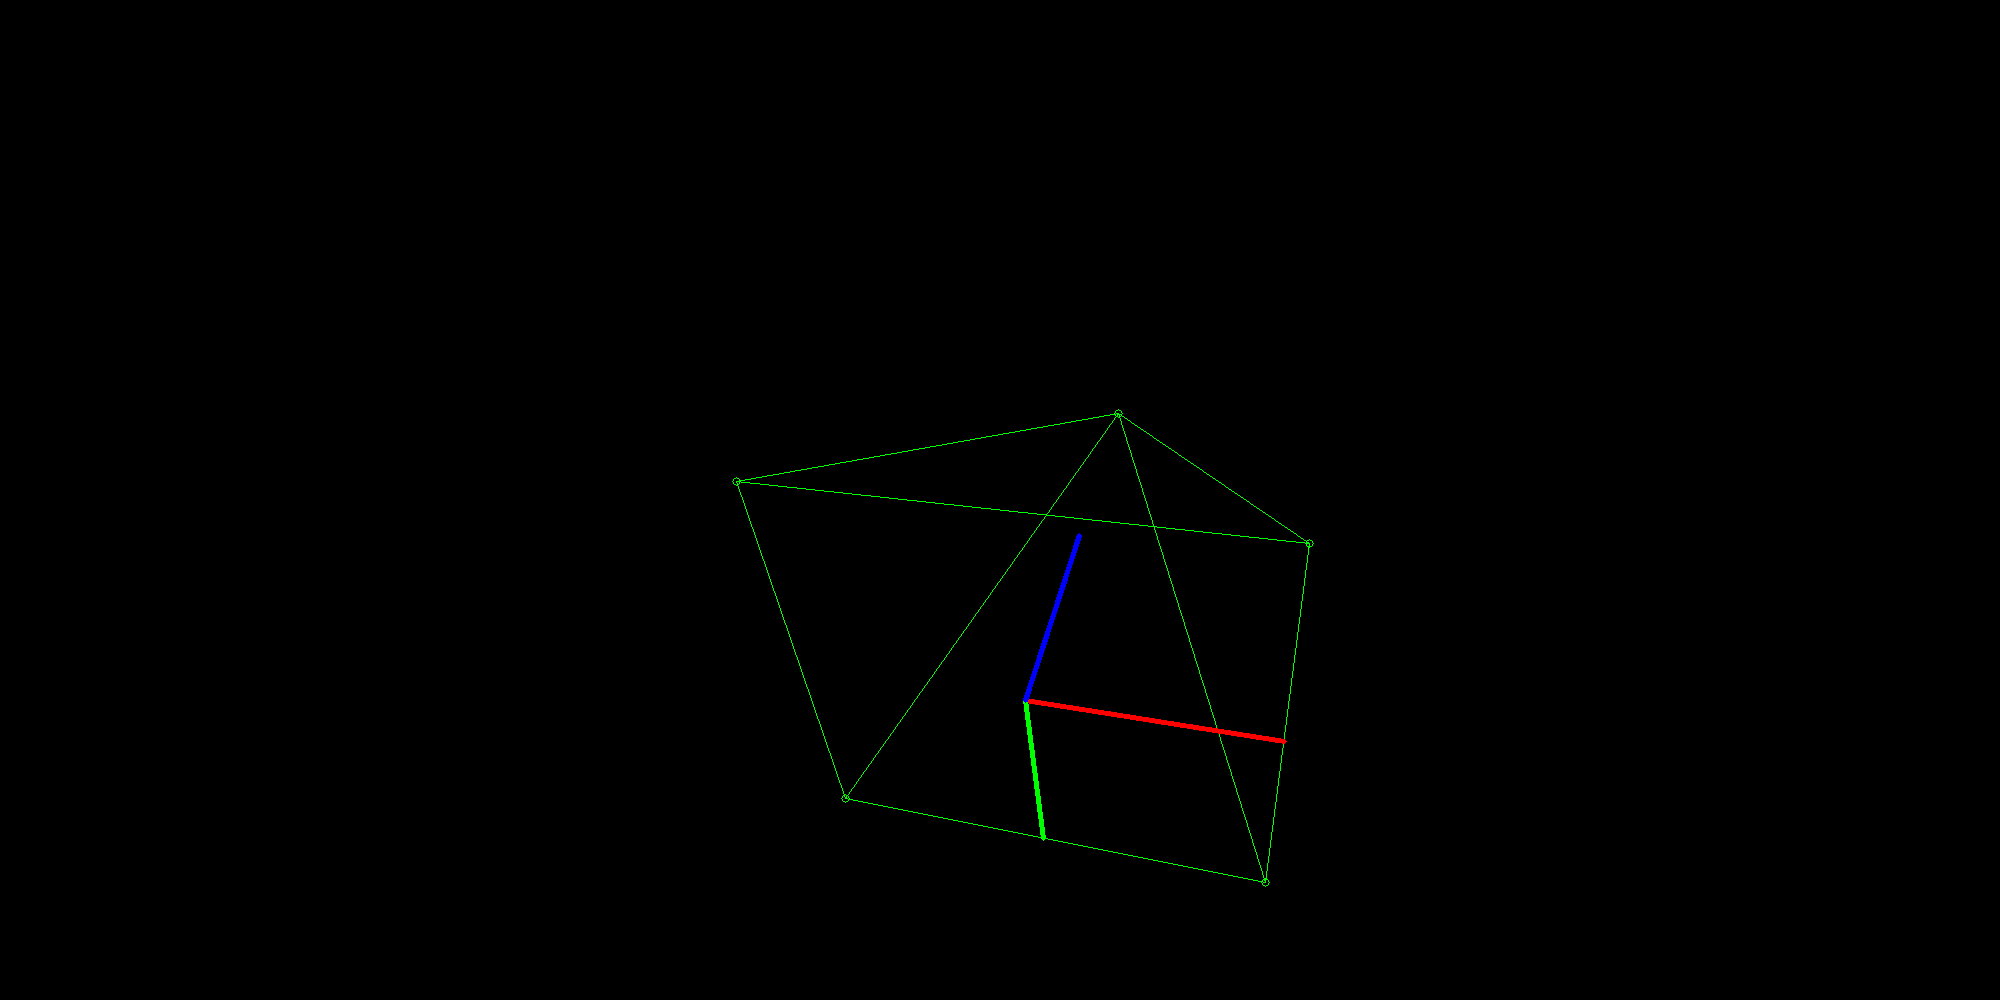

In [23]:
img_sintetica = np.zeros((1000, 2000, 3), dtype=np.uint8)
f = 1000 * 1
d = 4 * 1
mtx = np.array([[f,0,1000],[0,f,500],[0,0,1]], dtype=np.float32)
rvec = np.array([[0.7], [0.3], [0]], dtype=np.float32)
tvec = np.array([[0.1], [0.8], [d]])
pontos_projetados, _ = cv2.projectPoints(verts3d, rvec, tvec, mtx, dist)
for i, p1 in enumerate(pontos_projetados):
    if i + 2 < len(pontos_projetados):
        p2 = pontos_projetados[i+1].astype(np.uint).ravel()
    else:
        p2 = pontos_projetados[0].astype(np.uint).ravel()
    cv2.line(img_sintetica, p1.astype(np.uint).ravel(), p2, (0, 255, 0))
    cv2.line(img_sintetica, p1.astype(np.uint).ravel(), pontos_projetados[-1].astype(np.uint).ravel(), (0, 255, 0))
    cv2.circle(img_sintetica, p1.astype(np.uint).ravel(), 4, (0, 255, 0))
cv2.drawFrameAxes(img_sintetica, mtx, dist, rvec, tvec, 1)

PIL.Image.fromarray(cv2.cvtColor(img_sintetica, cv2.COLOR_BGR2RGB))

[![Dolly Zoom](https://upload.wikimedia.org/wikipedia/commons/c/c7/Contra-zoom_aka_dolly_zoom_animation.gif)](https://upload.wikimedia.org/wikipedia/commons/transcoded/5/5f/DollyZoomTest.ogv/DollyZoomTest.ogv.480p.vp9.webm "Dolly Zoom")

Entenda alguma das limitações que a Perspectiva de N Pontos tem. Principalmente devido ao fato de ser uma solução monocular.
Descreva o que acontece com a exatidão da solução à medida que a distância focal da lente aumenta, considerando o tamanho da imagem constante e o tamanho do objeto focalizado também constante. A exatidão da solução em metros aumenta, diminui ou permanece constante? Para todos os eixos ou o comportamente é diferente para algum eixo específico X, Y ou Z? Explique.
Escreva sua resposta na célula abaixo. (1 ponto)

**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**QUESTÃO DISCURSIVA**

Quanto maior a distância focal menor será o FOV. Um field of view menor implica em uma redução na perspectiva de profundidade. Isto terá impacto direto na solução da perpesctiva de n pontos, que terá mais dificuldades em encontrar as matrizes de translação e rotação com maior precisão.
Quantos aos eixos X e Y são esperados resultados diferentes, pois um menor FOV fará com que objetos distantes aparetem maiores. Isto implicará em um aumento na precisão de resposta do algoritmo para estes eixos. 

**ATENÇÃO**

**ATENÇÃO**


## Calibração Estéreo

Na calibração estéreo, a ideia é encontrar a pose de uma câmera com relação a outra, aproveitando-se dos parâmetros intrísecos que já foram estimados na calibração monocular (mas eles também podem ser refinados se necessário).

In [24]:
def get_verts2d(path, nverts, criteria):
    pathnames = [str(p) for p in sorted(path.glob('*.png'))]
    imgs = [cv2.cvtColor(cv2.imread(p)[:,:,0], cv2.COLOR_BAYER_GB2GRAY) for p in pathnames]
    verts2d = [cv2.findChessboardCorners(img, nverts) for img in imgs]
    return [cv2.cornerSubPix(img, v, (7,7), (-1,-1), criteria) if r else None for img, (r, v) in zip(imgs, verts2d)]

tamanho_imagem = cv2.imread(str(imgs_esq_path/'00.png')).shape[1::-1]
nverts = (10, 7)

l_quadrado = 0.1 # metros
verts3d = np.zeros((nverts[0] * nverts[1], 3), dtype=np.float32)
i = 0
for y in range(nverts[1]):
    for x in range(nverts[0]):
        verts3d[i] = (x * l_quadrado, y * l_quadrado, 0)
        i += 1

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 5e-4)
verts2d_esq = get_verts2d(imgs_esq_path, nverts, criteria)
verts2d_dir = get_verts2d(imgs_dir_path, nverts, criteria)

Faça a calibração estéreo de forma a achar a rotação e translação de uma câmera com relação a outra. Use a função `cv2.stereoCalibrateExtended`. Tome cuidado que `objectPoints` é uma lista de pontos 3d de cada imagem (`verts3d` que é constante). Outro cuidado é para filtrar os `verts2d` para ficar apenas com os pares que existem em ambas as câmeras.
A calibração estéreo também conseguiria estimar os parâmetros intrísecos, mas é mais estável fazer isso em uma calibração mono (a quantidade de parâmetros para cada estimação diminui e fica mais comportado). A flag padrão já é cv2.CALIB_FIX_INTRINSIC então não precisa se preocupar. Para os vetores R e T de argumentos pode passar `None` ou uma matriz zerada.  (1,5 pontos)

In [25]:
def calibra_estereo(verts3d, verts2d_esq, verts2d_dir, cam_esq, cam_dir, tamanho_imagem):
    """
    Executa a calibração estéreo de um par de câmeras, sem otimizar os parâmetros intrísecos
    :param verts3d: As coordenadas dos pontos 3d dos marcadores em seu referencial próprio
    :param verts2d_esq: Os pontos 2d dos marcadores na imagem da câmera esquerda
    :param verts2d_dir: Os pontos 2d dos marcadores na imagem da câmera direita
    :param cam_esq: Tupla com a matriz intríseca e coeficientes de distorção da câmera esquerda
    :param cam_dir: Tupla com a matriz intríseca e coeficientes de distorção da câmera direita
    :param tamanho_imagem: Tupla com o tamanho da imagem em pixels em largura por altura
    Retorna o erro de reprojeção médio de toda a calibração, a matriz de rotação e vetor de translação que levam 
    pontos 3d do referencial da câmera da esquerda para a direita, a matriz essencial e a fundamental dessa 
    transformação, e o erro de reprojeção médio para cada imagem.
    """
    me, de = cam_esq
    md, dd = cam_dir
    for i,A in enumerate(verts2d_esq) :
      B = verts2d_dir[i]
      if np.any(np.equal(A,None)) or np.any(np.equal(B,None)) :
        del verts2d_esq[i]
        del verts2d_dir[i]
    _,_,_,_,_,matriz_rotacao,translacao,matriz_essencial,matriz_fundamental,erro_para_cada_imagem = cv2.stereoCalibrateExtended(np.repeat(verts3d[np.newaxis, :, :],len(verts2d_dir) , axis=0),\
                                                                                                                                verts2d_esq,verts2d_dir,me,de,md,dd,\
                                                                                                                                tamanho_imagem,None,None)
    erro_medio = np.mean(erro_para_cada_imagem);    
    return erro_medio, matriz_rotacao, translacao, matriz_essencial, matriz_fundamental, erro_para_cada_imagem

In [26]:
cam_esq = (np.array([[1.27677228e+03, 0.00000000e+00, 9.46863329e+02],
                     [0.00000000e+00, 1.28093814e+03, 5.26800967e+02],
                     [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype=np.float32),
    np.array([ 0.00463763,  0.00506855, -0.00252541, -0.00054011,  0.        ], dtype=np.float32))
cam_dir = (np.array([[1.28316167e+03, 0.00000000e+00, 9.83705999e+02],
                     [0.00000000e+00, 1.28959033e+03, 4.74866554e+02],
                     [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
    np.array([ 0.00438509,  0.01102175, -0.00740251,  0.00029485,  0.        ], dtype=np.float32))
err, rmat, T, E, F, erro_para_cada_imagem = calibra_estereo(verts3d, verts2d_esq[:-6], 
                                                            verts2d_dir[:-6], cam_esq, cam_dir, tamanho_imagem)
assert err < 0.7
assert np.mean(erro_para_cada_imagem) < 0.7
assert erro_para_cada_imagem.shape == (28, 2)
assert np.linalg.norm(rmat - np.array([[ 0.9330993 , -0.00167611,  0.35961491],
                                       [-0.00388421,  0.99988383,  0.01473875],
                                       [-0.35959784, -0.01514954,  0.9329844 ]])) < 1e-5
assert np.linalg.norm(T - np.array([[-9.54630632e-01],[ 3.48152961e-04],[ 1.50440555e-01]])) < 1e-5
assert np.linalg.norm(E - np.array([[ 4.59148223e-04, -1.50428353e-01, -1.89248456e-03],
                                    [-2.02907133e-01, -1.47143694e-02,  9.44756152e-01],
                                    [ 3.38312816e-03, -9.54519153e-01, -1.41952640e-02]])) < 1e-5
assert np.linalg.norm(F - np.array([[-3.71746733e-09,  1.21397368e-06, -6.16439367e-04],
                                    [ 1.63463644e-06,  1.18154655e-07, -1.13275774e-02],
                                    [-8.07724752e-04,  8.63399180e-03,  1.00000000e+00]])) < 1e-5

Veja que um dos valores de retorno do OpenCV são as matrizes Essencial (E) e Fundamental (F). Explique o que são essas matrizes e como elas relacionam os pontos observados por uma câmera para outra. Explique também como elas se relacionam com as matrizes intrínsecas, matrizes de rotação e vetores de translação entre as câmeras. Escreva sua resposta na célula abaixo, pode usar latex se quiser. (1 ponto)

**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**QUESTÃO DISCURSIVA**

A matriz essencial relaciona os pontos de imagem correspondentes entre as duas câmeras, dada pela seguinte relação :

$ X'^{\,T}EX = 0$. 

Onde X' e X são as coordenadas em cada uma das câmeras já considerando a correção pelo parâmetros extrinsicos e intrísecos.

A matriz fundamental também relaciona as coordenadas dos pixels nas duas câmeras só que de forma mais geral do que a matriz essencial, sem necessidade de conhecer os parâmetros intrínsecos e extrensícos.

$p_{im,cam1}^TFp_{im,cam2} = 0$,

Onde $p_{im,cam1}$ e $p_{im,cam2}$ são as posições dos pixels para cada uma das câmeras.

A matriz fundamental e essêncial se relacionam da seguinte maneira :

$F = K_{intriseca,cam1}E K_{intriseca,cam2}$

**ATENÇÃO**

**ATENÇÃO**


## Retificação Estéreo

Encontrar homografias em cada uma das câmeras que torna as linhas epipolares paralelas (epipolos no infinito).


Use a função `cv2.stereoRectify` para encontrar a matriz de retificação de cada uma das câmeras. Além dessa homografia (que é justamente a rotação do centro de projeção), ela também atualiza a matriz de projeção (que é a multiplicação da matriz intrínseca pela extrínseca `K[RT]`) (1,5 pontos)

In [27]:
def retifica_estereo(cam_esq, cam_dir, tamanho_imagem, matriz_rotacao_entre_cameras, translacao_entre_cameras):
    """
    Faz a retificação estéreo a fim de transformar as linhas epipolares das projeções em linhas horizontais
    :param cam_esq: Tupla com a matriz intríseca e coeficientes de distorção da câmera esquerda
    :param cam_dir: Tupla com a matriz intríseca e coeficientes de distorção da câmera direita
    :param tamanho_imagem: Tupla com o tamanho da imagem em pixels em largura por altura
    :param matriz_rotacao_entre_cameras: A matriz de rotação da câmera esquerda medida no referencial da direita
    :param translação_entre_cameras: A posição da câmera esquerda medida no referencial da câmera direita
    Retorna as matrizes de retificação esquerda e direita, as matrizes de projeção esquerda e direita, a matriz
    de mapeamento de disparidade para profundidade.
    """
    retifica_mat_esq,retifica_mat_dir,projeta_mat_esq,projeta_mat_dir,Q,_,_ = cv2.stereoRectify(cam_esq[0],cam_esq[1],cam_dir[0],cam_dir[1],\
                                                                                                tamanho_imagem,matriz_rotacao_entre_cameras,\
                                                                                                translacao_entre_cameras)
    return retifica_mat_esq, retifica_mat_dir, projeta_mat_esq, projeta_mat_dir, Q

def aplica_mapeamento(imagem, cam_param, retifica_mat, projeta_mat, tamanho_imagem):
    mapeamentos = cv2.initUndistortRectifyMap(*cam_param, retifica_mat, projeta_mat, tamanho_imagem, cv2.CV_32FC1)
    return cv2.remap(imagem, *mapeamentos, cv2.INTER_LANCZOS4)

In [28]:
R1, R2, P1, P2, Q = retifica_estereo(cam_esq, cam_dir, tamanho_imagem, rmat, T)
assert np.linalg.norm(R1 - np.array([[ 9.77703755e-01,  3.42425370e-04,  2.09988690e-01],
                                     [-1.94226256e-03,  9.99970641e-01,  7.41250433e-03],
                                     [-2.09979987e-01, -7.65508649e-03,  9.77675715e-01]])) < 1e-5
assert np.linalg.norm(P1 - np.array([[1.28526422e+03, 0.00000000e+00, 9.02986206e+02, 0.00000000e+00],
                                     [0.00000000e+00, 1.28526422e+03, 4.93165016e+02, 0.00000000e+00],
                                     [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])) < 1e-5

Observe como as imagens ficam após a retificação

In [29]:
img_esq = cv2.cvtColor(cv2.imread(str(imgs_esq_path/'23.png'), cv2.IMREAD_ANYCOLOR), cv2.COLOR_BAYER_GB2RGB)
img_dir = cv2.cvtColor(cv2.imread(str(imgs_dir_path/'23.png'), cv2.IMREAD_ANYCOLOR), cv2.COLOR_BAYER_GB2RGB)

img_esq_ret_full = aplica_mapeamento(img_esq, cam_esq, R1, P1, tamanho_imagem)
img_dir_ret_full = aplica_mapeamento(img_dir, cam_dir, R2, P2, tamanho_imagem)
img_esq_ret_full = np.clip(img_esq_ret_full.astype(np.float32)*1.3, 0, 255).astype(np.uint8)
img_dir_ret_full = np.clip(img_dir_ret_full.astype(np.float32)*1.3, 0, 255).astype(np.uint8)

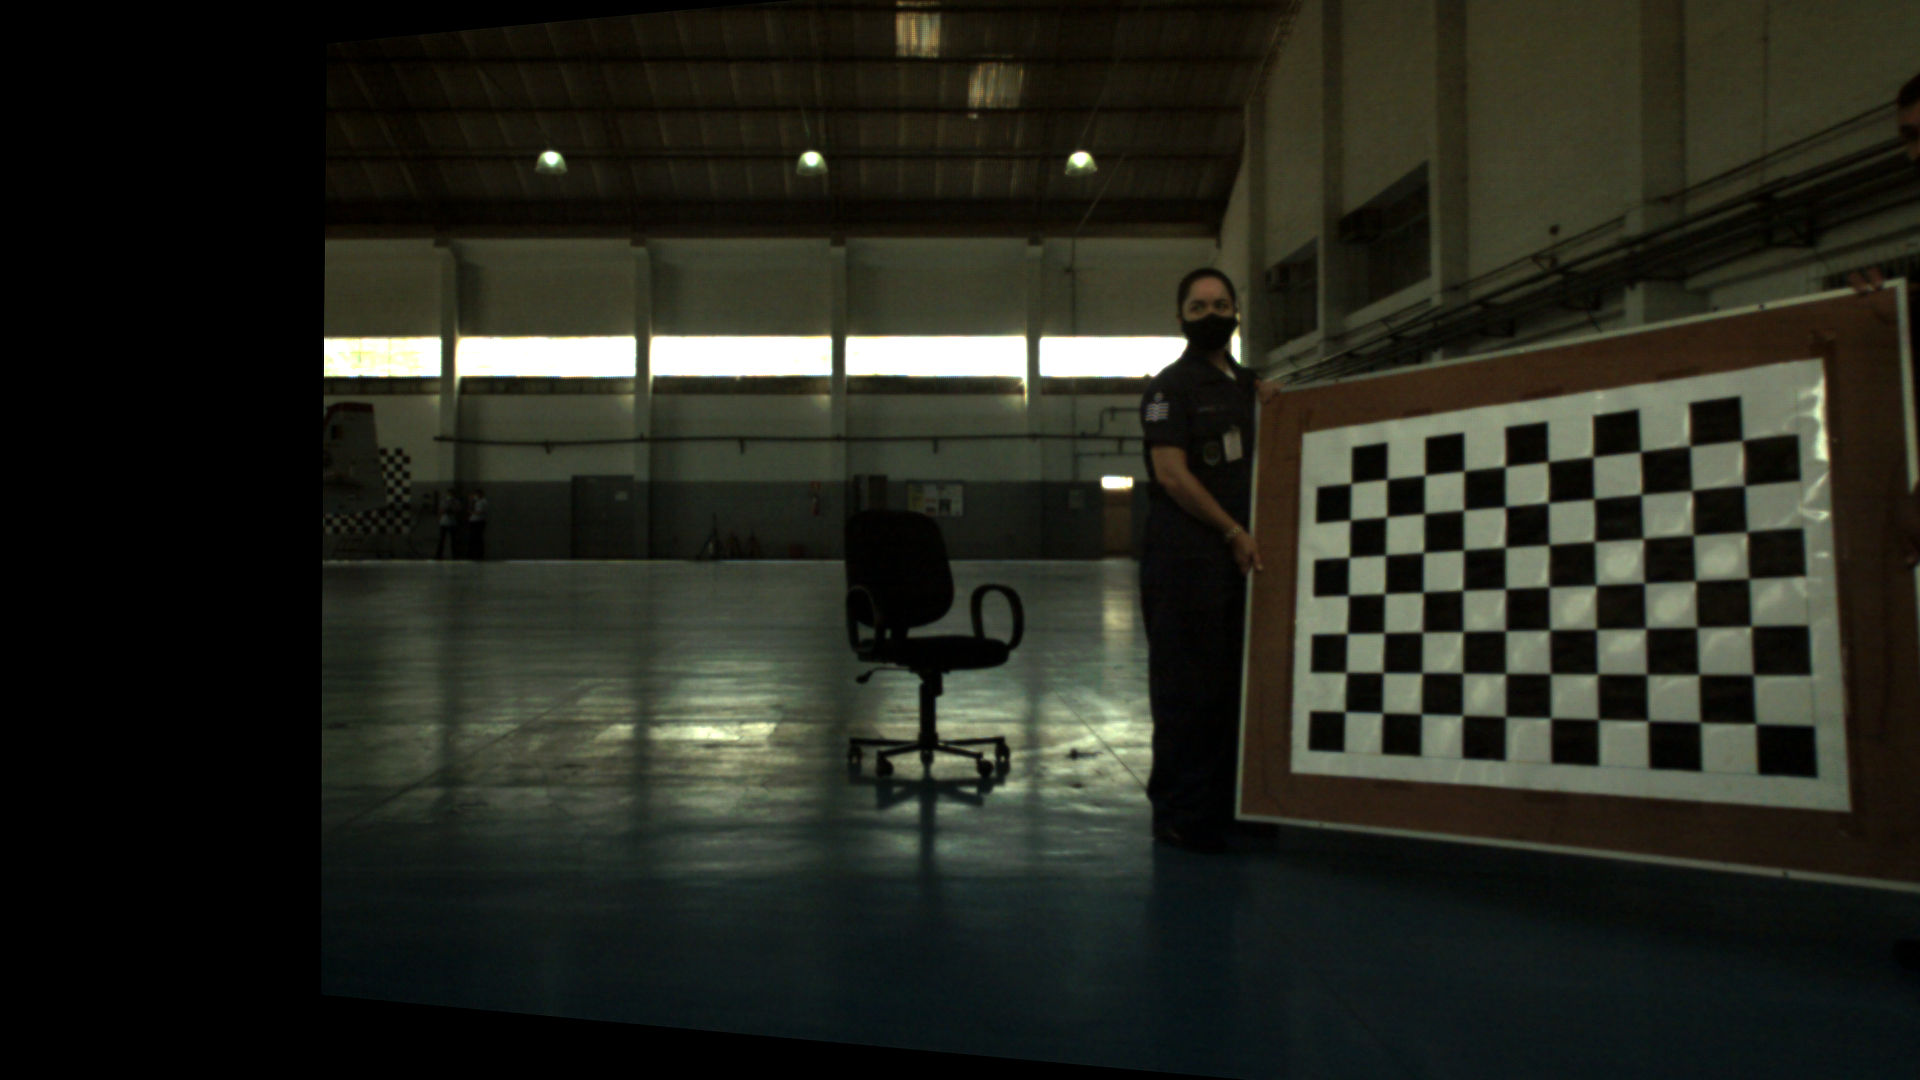

In [30]:
PIL.Image.fromarray(img_esq_ret_full)

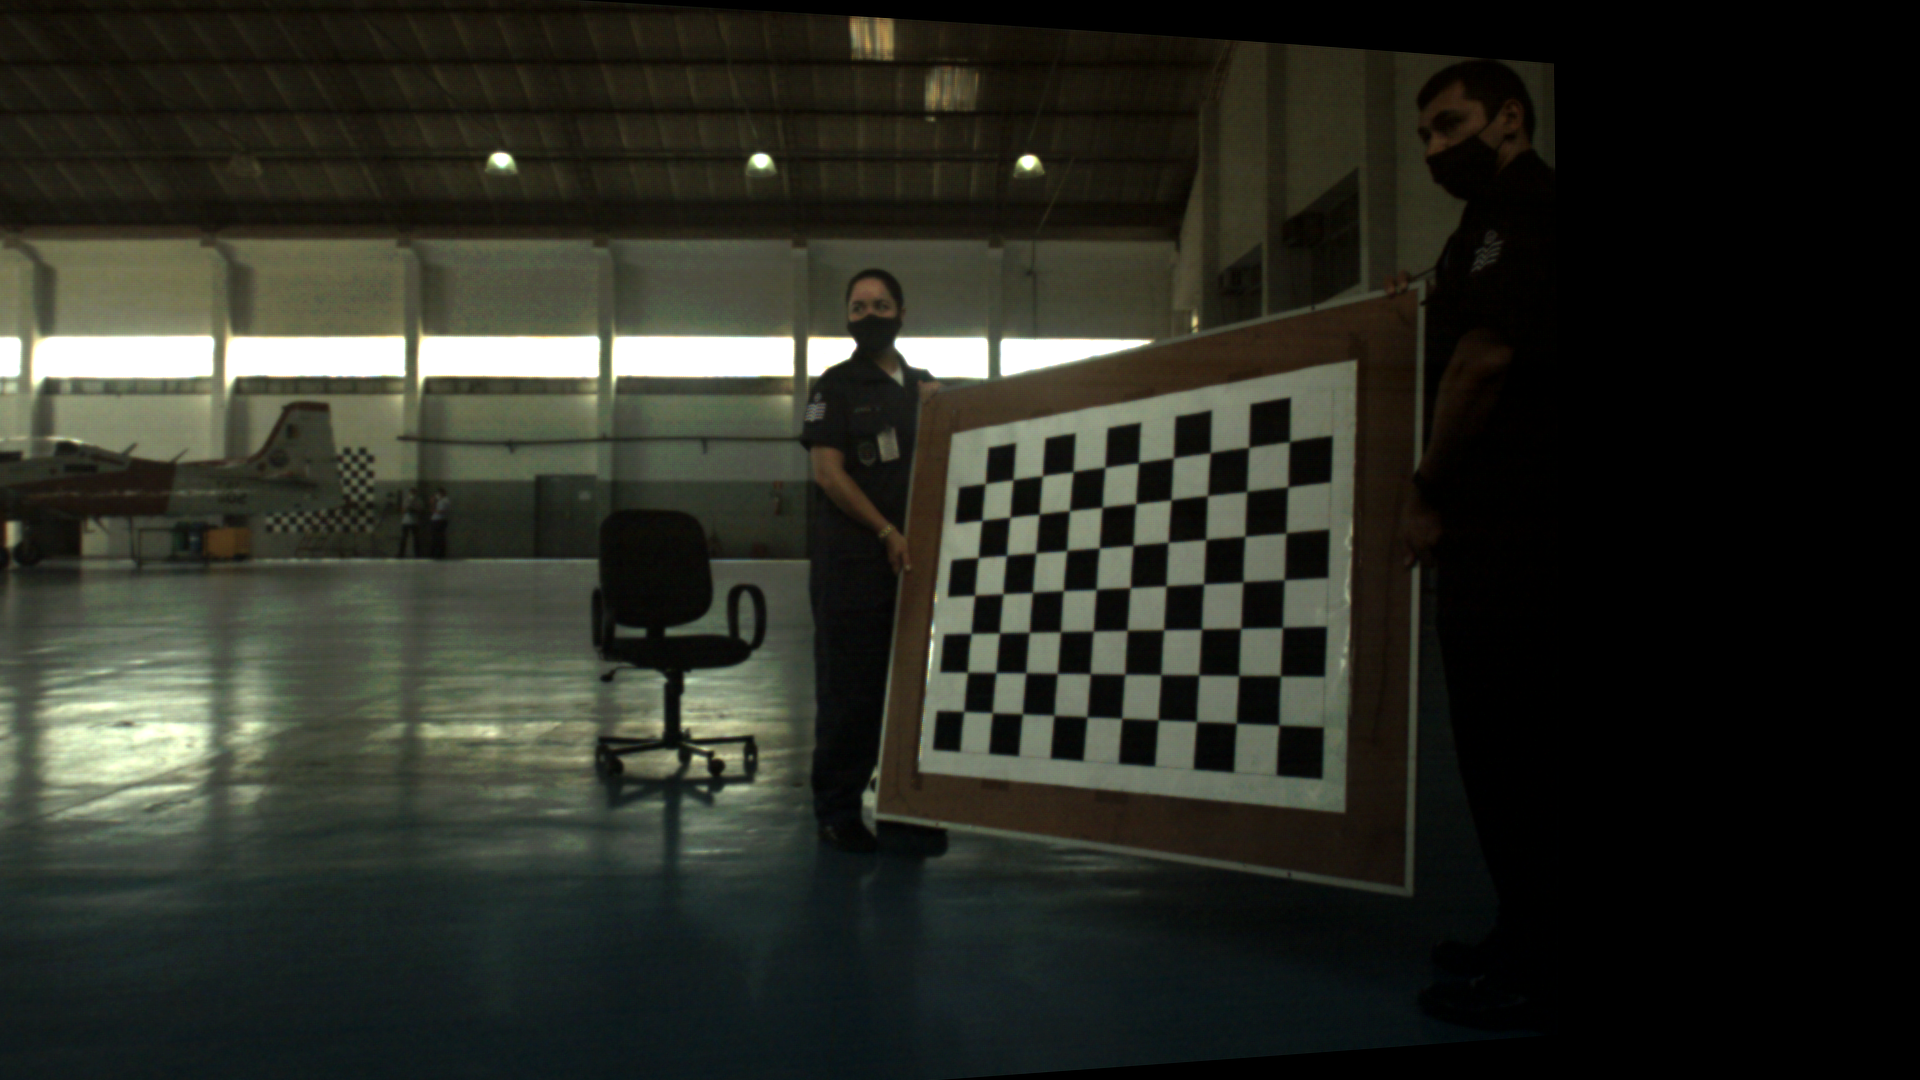

In [31]:
PIL.Image.fromarray(img_dir_ret_full)

## Disparidade

Vamos agora usar um correlacionador que faz uso das imagens retificadas, isto é, ele supoem que o vínculo epipolar acontece apenas nas linhas horizontais (epipolares paralelas e horizontais).

Sinta-se livre para mudar os parâmetros abaixo, sobretudo os valores de `blockSize` que define o tamanho da janela de correlação e o `speckleWindowSize` e `speckleRange` que filtram pontos espúrios. Perceba que como as câmeras estão afastadas de 1 metro (e também estava inclindas convergentemente), a disparidade chega a ser da ordem de até 500 pixels para o ponto mais próximo, o que está evidenciado pelo `numDisparities=16*32 ` = 512 (160 depois do resize). Apenas para pontos no infinito teríamos `minDisparity=0`.

Observe que devido à falta de textura na imagem, sobretudo no chão e nas paredes, a maior parte dos pontos ficou sem determinação de profundidade, porque não encontrou o seu par (não deu match). Como as disparidades também são grandes ele fica encontrado muitas correlações espúrias.

Veja também que precisamos diminuir o tamanho da imagem para deixar o resultado com menos ruídos, experimente outros valores de s (maiores ou menores) que diminuem ou aumenta a escala.

(238, 422, 3)


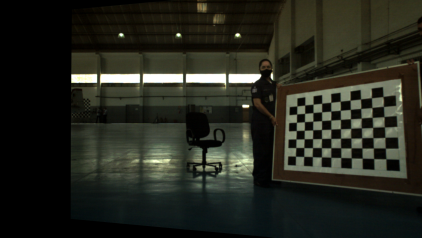

In [32]:
s = 0.22
img_esq_ret = cv2.resize(img_esq_ret_full, None, None, s, s, cv2.INTER_AREA)
img_dir_ret = cv2.resize(img_dir_ret_full, None, None, s, s, cv2.INTER_AREA)
print(img_esq_ret.shape)
PIL.Image.fromarray(img_esq_ret)

[]

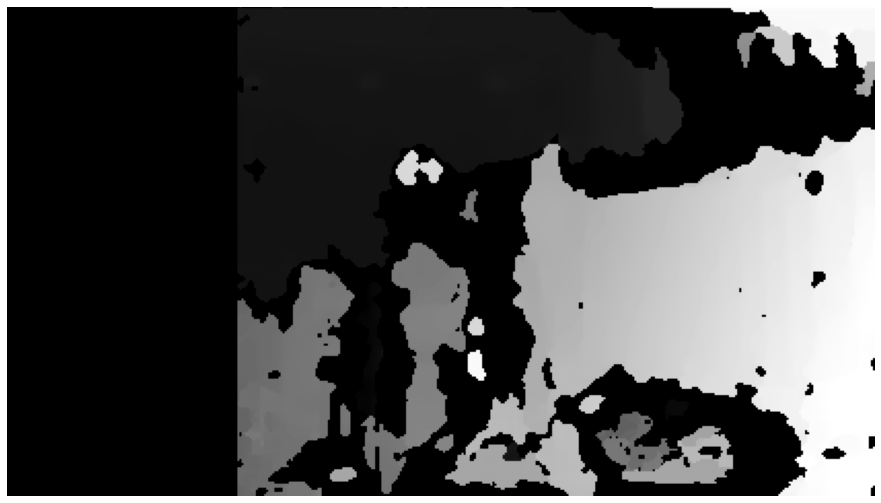

In [33]:
correlacionador = cv2.StereoSGBM_create(minDisparity=0, numDisparities=int(16*32*s), blockSize=11, 
                  P1=8*3*11*11, P2=32*3*11*11, speckleWindowSize = 50, speckleRange = 2, disp12MaxDiff=20)
corr_esq = correlacionador.compute(img_esq_ret, img_dir_ret)

plt.figure(figsize=(16,9))
plt.axis(False)
plt.imshow(corr_esq, cmap='gray', vmin=0)
plt.plot()

Podemos reaplicar o correlacionador com as imagens trocadas e depois utilizar um filtro entre os resultados antípodos:

Observe que as cores ficam invertidas, na realidade é porque a disparidade que antes estava positiva, ficou negativa.

[]

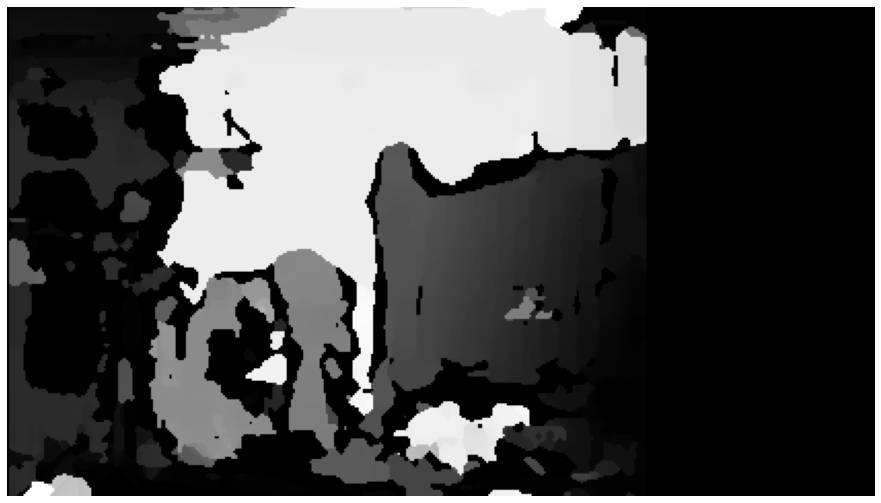

In [34]:
correlacionador_inverso = cv2.ximgproc.createRightMatcher(correlacionador)
corr_dir = correlacionador_inverso.compute(img_dir_ret, img_esq_ret)

plt.figure(figsize=(16,9))
plt.axis(False)
plt.imshow(corr_dir, cmap='gray', vmax=0)
plt.plot()

E aplicando o filtro:

[]

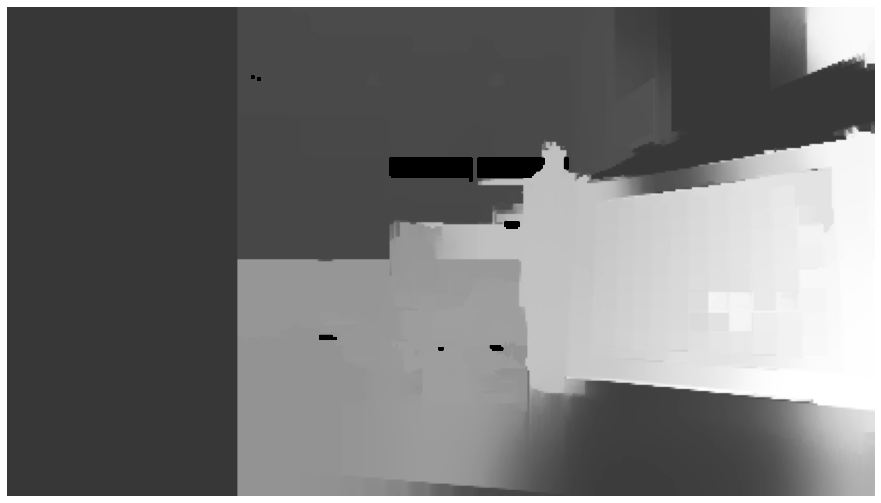

In [35]:
filtro = cv2.ximgproc.createDisparityWLSFilter(matcher_left=correlacionador)
filtro.setLambda(1300)
filtro.setSigmaColor(1.9)
resultado_filtrado = filtro.filter(np.int16(corr_esq), img_esq_ret, None, np.int16(corr_dir))

plt.figure(figsize=(16,9))
plt.axis(False)
plt.imshow(resultado_filtrado, cmap='gray',vmin=-16*16*2)
plt.plot()

Para uma imagem com mais textura e com disparidades menores (da ordem de apenas 16 pixels): 

(OBS ela já estão retificadas)

In [36]:
iesq = cv2.imread(str(tsukuba_path/"tsukuba_l.png"), cv2.IMREAD_ANYCOLOR)
idir = cv2.imread(str(tsukuba_path/"tsukuba_r.png"), cv2.IMREAD_ANYCOLOR)

[]

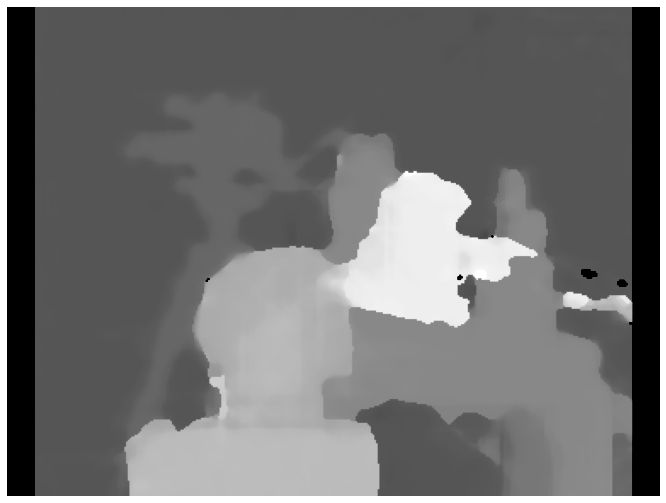

In [37]:
correlacionador = cv2.StereoSGBM_create(minDisparity=-16, numDisparities=32, blockSize=9, 
                  P1=4*3*9*9, P2=16*3*9*9, speckleWindowSize = 50, speckleRange = 1, disp12MaxDiff=20)

corr_esq = correlacionador.compute(iesq, idir)


plt.figure(figsize=(16,9))
plt.axis(False)
plt.imshow(corr_esq, cmap='gray', vmin=0)
plt.plot()